In [61]:
import torch 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

In [47]:
H_raw = np.array(np.load('../data/processed_data/H_data.npy'))
MDD_raw = np.array(np.load('../data/processed_data/MDD_data.npy'))

X = np.array([x.ravel() for x in np.vstack((H_raw, MDD_raw))])
y = np.hstack((np.zeros(len(H_raw)), np.ones(len(MDD_raw))))


X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8)

In [54]:
model = MLPClassifier([361, 50, 2], activation = 'relu', solver = 'adam',
            batch_size = 32, early_stopping = True, learning_rate = 'adaptive'
)

model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_acc = np.mean(train_pred == y_train)
test_acc = np.mean(test_pred == y_test)

print('Train Accuracy: ', train_acc, '\nTest Accuracy: ', test_acc)


Train Accuracy:  0.9703367465428059 
Test Accuracy:  0.9097818437719916


              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91      3464
         1.0       0.90      0.92      0.91      3641

    accuracy                           0.91      7105
   macro avg       0.91      0.91      0.91      7105
weighted avg       0.91      0.91      0.91      7105



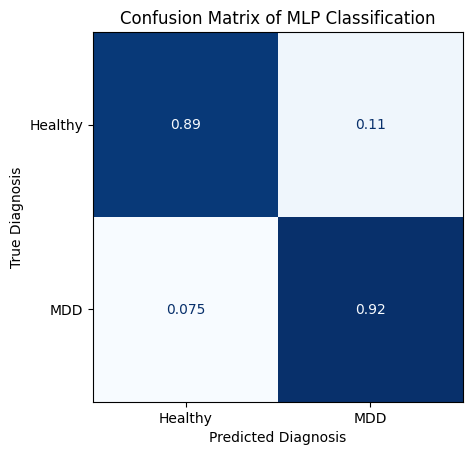

In [75]:
print(classification_report(y_test, test_pred))
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=['Healthy', 'MDD'],
        cmap=plt.cm.Blues,
        normalize='true',
        colorbar = False
    )
disp.confusion_matrix
plt.title('Confusion Matrix of MLP Classification')
plt.xlabel('Predicted Diagnosis')
plt.ylabel('True Diagnosis')
plt.show()